# FA22 BIODS220 Final Project
## Convolutional Model for MRI Scans
#### Authors: Shanduojiao Jiang (sj99@stanford.edu), kelly Brennan (kbrenn@stanford.edu)

In [1]:
import os
import sys
import cv2
import pydicom
import dicom_numpy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

## Section 1: Data Manipulation

#### Example MRI slices that are stored in DICOM format

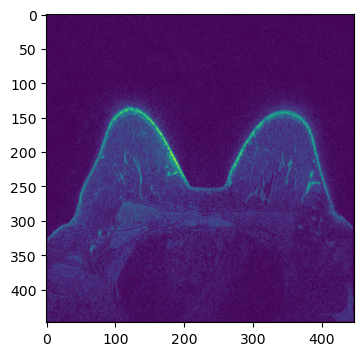

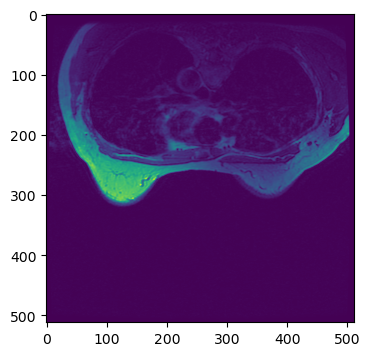

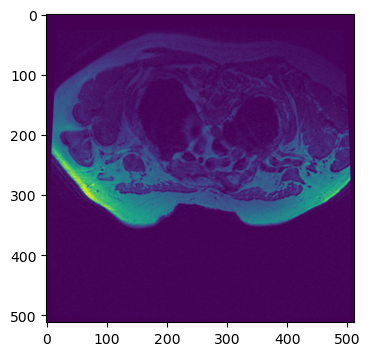

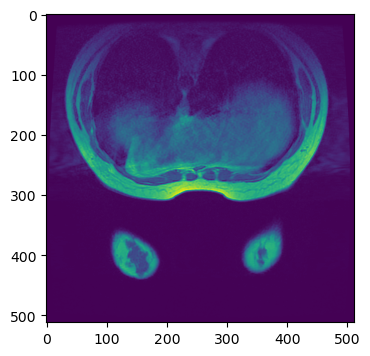

In [2]:
examples = ["../data/images/dicom/MRI_001/1-047.dcm", "../data/images/dicom/MRI_011/1-12.dcm", 
            "../data/images/dicom/MRI_010/1-03.dcm", "../data/images/dicom/MRI_118/1-57.dcm"]
for image_path in examples:
    ds = pydicom.dcmread(image_path)
    plt.figure(figsize=(4,4))
    plt.imshow(ds.pixel_array)

#### Define functions to convert the DICOM files to JPG and stack the slices for all patients

In [3]:
def convert_dicom_slices(dicom_folder, jpg_folder):
    # Step 1. prepare the input(.dcm) and output(.jpg) filepath 
    dcm_jpg_map = {}
    for dicom_f in os.listdir(dicom_folder):
        dicom_filepath = os.path.join(dicom_folder, dicom_f)
        jpg_f = dicom_f.replace('.dcm', '.jpg') 
        jpg_filepath = os.path.join(jpg_folder,jpg_f)
        dcm_jpg_map[dicom_filepath] = jpg_filepath
    # Now, dcm_jpg_map is key,value pair of input dcm filepath and output jpg filepath

    # Step 2. process the image by input/output information
    for dicom_filepath, jpg_filepath in dcm_jpg_map.items():
        # convert dicom file into jpg file
        dicom = pydicom.read_file(dicom_filepath)
        np_pixel_array = dicom.pixel_array
        cv2.imwrite(jpg_filepath, np_pixel_array)

In [4]:
def stack_jpg_images(jpg_folder, target_shape=(256,256)):
    unstacked_list = []
    for jpg_f in os.listdir(jpg_folder):
        jpg_path = os.path.join(jpg_folder, jpg_f)
        img = cv2.resize(cv2.imread(jpg_path), dsize=target_shape, interpolation=cv2.INTER_CUBIC)
        unstacked_list.append(img)
    return np.array(unstacked_list)

#### Extract the corresponding death and recurrence label for that patient

In [9]:
base_path = "../data/images/"
MRIs = os.listdir("../data/images/dicom")
labels_df = pd.read_csv("../data/Labeled_Merged_Imaging_Clinical_Features.csv")

# A list of numpy arrays to hold the converted and stacked MRI slices
MRI_numpy = []
death_labels = []
recur_labels = []

for mri in MRIs:
    dicom_folder = base_path + "dicom/" + mri
    jpg_folder = base_path + "jpg/" + mri
    convert_dicom_slices(dicom_folder, jpg_folder)
    curr_numpy = stack_jpg_images(jpg_folder, target_shape=(256,256))
    MRI_numpy.append(curr_numpy)
    
    curr_death_label = int(labels_df[labels_df["Patient ID"] == "Breast_" + mri]["death_label"])
    curr_recur_label = int(labels_df[labels_df["Patient ID"] == "Breast_" + mri]["recur_label"])
    death_labels.append(curr_death_label)
    recur_labels.append(curr_recur_label)

In [10]:
print("Total number of MRI patients:", len(MRIs))
print("Percentage of positive death labels:", sum(death_labels)/len(death_labels)*100)
print("Percentage of positive recur labels:", sum(recur_labels)/len(death_labels)*100)

Total number of MRI patients: 39
Percentage of positive death labels: 38.46153846153847
Percentage of positive recur labels: 48.717948717948715


#### Convert all MRI image data into a uniform shape (256,256,3) numpy array

In [12]:
# Convert the labels into numpy arrays
death_labels = np.array(death_labels)
recur_labels = np.array(recur_labels)

# For each patient, sum over the slices to get one aggregated MRI scan of shape (256, 256, 3)
MRI_numpy_reshaped = []
for mri in MRI_numpy:
    MRI_numpy_reshaped.append(np.sum(mri, 0))
MRI_numpy_reshaped = np.array(MRI_numpy_reshaped)
MRI_numpy_reshaped.shape

(39, 256, 256, 3)

At this point, our X would be MRI_numpy_reshaped, with shape of (n_patients, 256, 256, 3), y would be death_labels and recur_labels of shape (n_patients,)

## Section 2. Transfer Learning using Pretrained ResNet

### Death Prediction

In [13]:
X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(MRI_numpy_reshaped, death_labels, test_size=0.2, random_state=1)
X_train_death, X_val_death, y_train_death, y_val_death = train_test_split(X_train_death, y_train_death, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
len(X_train_death)

23

In [88]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                                                 input_shape=(256,256,3),
                                                 weights="imagenet")
model = tf.keras.models.Sequential([
    pretrained_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 8, 2048)        8192      
_________________________________________________________________
flatten_15 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 131072)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 131073    
Total params: 23,726,977
Trainable params: 23,669,761
Non-trainable params: 57,216
_________________________________________________________________


In [89]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", "AUC", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [90]:
EPOCH=30
hist = model.fit(X_train_death, y_train_death, epochs=EPOCH, validation_data=(X_val_death, y_val_death))

Epoch 1/30
1/1 [==============================] - 7s 7s/step - loss: 0.9803 - accuracy: 0.6087 - auc: 0.4318 - recall_13: 0.5455 - precision_13: 0.6000 - val_loss: 3.7617 - val_accuracy: 0.3750 - val_auc: 0.0833 - val_recall_13: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 346ms/step - loss: 0.3129 - accuracy: 0.8261 - auc: 0.9545 - recall_13: 0.8182 - precision_13: 0.8182 - val_loss: 2.9076 - val_accuracy: 0.2500 - val_auc: 0.1667 - val_recall_13: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 347ms/step - loss: 0.0836 - accuracy: 1.0000 - auc: 1.0000 - recall_13: 1.0000 - precision_13: 1.0000 - val_loss: 2.6078 - val_accuracy: 0.2500 - val_auc: 0.1667 - val_recall_13: 0.5000 - val_precision_13: 0.1667
Epoch 4/30
1/1 [==============================] - 0s 348ms/step - loss: 0.0339 - accuracy: 1.0000 - auc: 1.0000 - recall_13: 1.0000 - precision_13: 1.0000 - val_loss: 2.3028 - val_accuracy:

In [91]:
model.evaluate(X_test_death, y_test_death)

1/1 [==============================] - 0s 57ms/step - loss: 0.4593 - accuracy: 0.7500 - auc: 0.7500 - recall_13: 0.5000 - precision_13: 0.5000


[0.4593440890312195, 0.75, 0.7499999403953552, 0.5, 0.5]

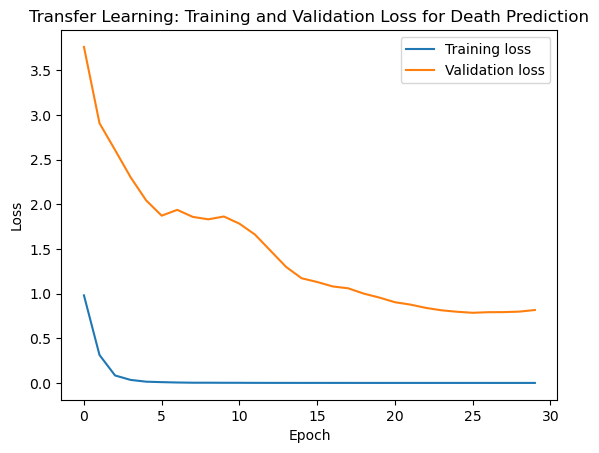

In [94]:
plt.figure()
plt.plot(range(EPOCH), hist.history['loss'], label='Training loss')
plt.plot(range(EPOCH), hist.history['val_loss'], label='Validation loss')
plt.title("Transfer Learning: Training and Validation Loss for Death Prediction")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Recurrence Prediction

In [95]:
X_train_recur, X_test_recur, y_train_recur, y_test_recur = train_test_split(MRI_numpy_reshaped, recur_labels, test_size=0.2, random_state=1)
X_train_recur, X_val_recur, y_train_recur, y_val_recur = train_test_split(X_train_recur, y_train_recur, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
len(X_train_recur)

23

In [112]:
print("Number of train | val | test:", len(X_train_recur), len(X_val_recur), len(X_test_recur))

Number of train | val | test: 23 8 8


In [107]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                                                 input_shape=(256,256,3),
                                                 weights="imagenet")
model = tf.keras.models.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_18 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 131072)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 131073    
Total params: 23,718,785
Trainable params: 23,665,665
Non-trainable params: 53,120
_________________________________________________________________


In [108]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", "AUC", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [109]:
EPOCH=30
hist = model.fit(X_train_recur, y_train_recur, epochs=EPOCH, validation_data=(X_val_recur, y_val_recur))

Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 1.1233 - accuracy: 0.5217 - auc: 0.4923 - recall_16: 0.5385 - precision_16: 0.5833 - val_loss: 3.9339 - val_accuracy: 0.6250 - val_auc: 0.2917 - val_recall_16: 0.0000e+00 - val_precision_16: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 346ms/step - loss: 0.7757 - accuracy: 0.7391 - auc: 0.6885 - recall_16: 0.7692 - precision_16: 0.7692 - val_loss: 2.9956 - val_accuracy: 0.2500 - val_auc: 0.0833 - val_recall_16: 0.0000e+00 - val_precision_16: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 0s 352ms/step - loss: 0.8524 - accuracy: 0.7391 - auc: 0.7077 - recall_16: 0.7692 - precision_16: 0.7692 - val_loss: 2.4516 - val_accuracy: 0.3750 - val_auc: 0.1667 - val_recall_16: 0.0000e+00 - val_precision_16: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 0s 343ms/step - loss: 0.1436 - accuracy: 0.9565 - auc: 0.9923 - recall_16: 1.0000 - precision_16: 0.9286 - val_loss: 1.9712 - val_a

In [110]:
model.evaluate(X_test_recur, y_test_recur)

1/1 [==============================] - 0s 58ms/step - loss: 1.3474 - accuracy: 0.5000 - auc: 0.6250 - recall_16: 0.7500 - precision_16: 0.5000


[1.347353219985962, 0.5, 0.625, 0.75, 0.5]

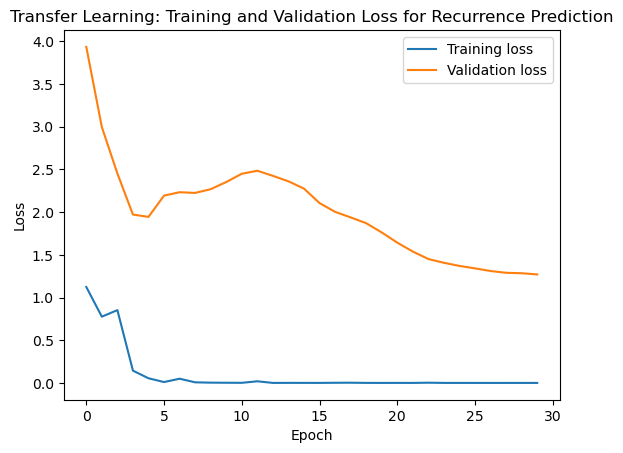

In [111]:
plt.figure()
plt.plot(range(EPOCH), hist.history['loss'], label='Training loss')
plt.plot(range(EPOCH), hist.history['val_loss'], label='Validation loss')
plt.title("Transfer Learning: Training and Validation Loss for Recurrence Prediction")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()